# Um projeto de *machine learning*

**Objetivos:**

- Aprender sobre o processo CRISP-DM;
- Aplicar o CRISP-DM a um projeto real de *machine learning*;
- Praticar análise exploratória;
- Construir *pipelines* de processamento de dados em scikit-learn;
- Entender o processo de construção, escolha e avaliação de modelos de *machine learning*;

## O processo CRISP-DM

CRISP-DM: CRoss-Industry Standard Process for Data Mining

***Atividade***: Leia o artigo "The CRISP-DM Model: The New Blueprint for Data Mining" (arquivo [`crisp-dm.pdf`](../resources/crisp-dm.pdf)) e responda:

1. O CRISP-DM é um processo de gerenciamento de equipes ou de estruturação de projetos?


2. Construa uma explicação do ciclo do CRISP-DM conforme visto na figura abaixo. Preste atenção especial para o fato de que temos setas bidirecionais entre "Business Understanding" e "Data Understanding", e entre "Data Preparation" e "Modeling" - porque os autores se deram ao trabalho de fazer isso?

![CRISP-DM diagram](../resources/crisp-dm.png)

Fonte: Kenneth Jensen, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons. https://commons.wikimedia.org/wiki/File:CRISP-DM_Process_Diagram.png

3. Segundo o artigo, qual a porcentagem do tempo que se gasta, tipicamente, em cada uma das fases?

## *California Housing*

Vamos trabalhar com um *dataset* de imóveis residenciais da Califórnia nos anos 1990.

### Obtendo os dados

In [1]:
from pathlib import Path

DATA_DIR = Path.cwd().parents[1] / 'datasets' / 'housing'
print(f'Saving data to {DATA_DIR}')

Saving data to c:\Users\lucca\OneDrive - Insper\Documentos\Insper\6° Semestre\Machine Learning\ml_labs\labs\datasets\housing


In [2]:
import tarfile
from urllib import request


def fetch_housing_data(data_dir: Path) -> None:
    '''Downloads the California Housing Prices dataset.

    Downloads the California Housing Prices dataset from Aurelien Geron's
    GitHub repository and saves it to the specified directory.

    Args:
        data_dir: The directory to which the dataset will be saved.

    Returns:
        None
    '''
    if not data_dir.exists():
        data_dir.mkdir(parents=True)

    # Fetch the housing data.
    HOUSING_URL = ('https://raw.githubusercontent.com/ageron/handson-ml2/'
                   'master/datasets/housing/housing.tgz')
    tgz_path = data_dir / 'housing.tgz'
    request.urlretrieve(HOUSING_URL, tgz_path)

    # Extract the housing data.
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=data_dir, filter='data')

In [3]:
fetch_housing_data(DATA_DIR)

In [4]:
import pandas as pd


def load_housing_data(data_dir: Path) -> pd.DataFrame:
    '''Loads the California Housing Prices dataset.

    Loads the California Housing Prices dataset from the specified directory.

    Args:
        data_dir: The directory from which the dataset will be loaded.

    Returns:
        A pandas DataFrame containing the California Housing Prices dataset.
    '''
    csv_path = data_dir / 'housing.csv'
    df = pd.read_csv(csv_path)
    return df

In [5]:
data = load_housing_data(DATA_DIR)

print(f'O dataset tem {data.shape[0]} linhas e {data.shape[1]} colunas.')
print('As colunas são:')
for column_name in data.columns:
    print(f'- "{column_name}"')


O dataset tem 20640 linhas e 10 colunas.
As colunas são:
- "longitude"
- "latitude"
- "housing_median_age"
- "total_rooms"
- "total_bedrooms"
- "population"
- "households"
- "median_income"
- "median_house_value"
- "ocean_proximity"


### Entendimento do negócio

Esses dados representam informações censitárias acerca de *distritos* residenciais no estado da California na década de 1990.

Atividade: Baseado nos nomes das colunas, você conseguiria escrever o significado de cada coluna?

Resposta: não muito bem.

Consultando o livro-texto da disciplina, capítulo 2, aprendemos que esses dados se referem aos distritos (conforme escrito no enunciado) e, portanto, são um pouco estranhos. Provavelmente significam, para cada distrito, o seguinte:

- `longitude`: a longitude do centro;
- `latitude`: a latitude do centro;
- `housing_median_age`: a idade mediana dos imóveis;
- `total_rooms`: essa é estranha, é a quantidade **total** de cômodos no distrito. Ou seja, a soma do número de cômodos de todos os imóveis;
- `total_bedrooms`: a soma do número de *quartos* de todos os imóveis;
- `population`: quantas pessoas moram no distrito;
- `households`: número de imóveis;
- `median_income`: renda mediana dos moradores do distrito;
- `median_house_value`: o valor mediano dos imóveis do distrito. Esta é a nossa variável a ser predita;
- `ocean_proximity`: só pelo nome é difícil saber a natureza exata desta variável. Trata-se de uma variável *categórica* indicando o "status" do distrito em relação à sua proximidade com o oceano Pacífico.

Atividade: Escreva o objetivo de negócios deste projeto

Prever o valor mediano de um distrito residencial da Califórnia 

### Análise exploratória

O objetivo da análise exploratória é "conhecer" os dados:

- Qual a distribuição de cada *feature*?

- Qual a natureza de cada *feature*?

    - Unidade de medida

    - Se é estritamente positiva ou se pode ser positiva ou negativa

    - Para que serve?

- Quais e como são as distribuições conjuntas de *features*? Em particular, como as *features* se relacionam com o *target*?

- Existem anomalias e erros?

    - Dados faltantes

    - "Saturação" de dados

    - Outliers

    - Desbalanceamento de classes

    - Dados duplicados

#### Análise exploratória: antes ou depois da separação treino-teste?

Durante o processo de modelagem vamos dividir os dados em dois conjuntos: "dados de treino" e "dados de teste". Devemos treinar nossos modelos com o conjunto de dados de treino, e avaliar seu desempenho no conjunto de teste, para que não nos enganemos com desempenhos preditivos excelentes no conjunto de treino e que não se reproduzem no conjunto de teste!

Atividade: Como se chama o fenômeno no qual temos um excelente desempenho no conjunto de treino e um desempenho bem menor no conjunto de teste?

Overfitting

Quando devemos fazer a análise exploratória?

- Antes da separação treino-teste, ou seja, no conjunto de dados completo?

- Depois da separação treino-teste, ou seja, usando apenas o conjunto de dados de treino?

Esta é uma pergunta difícil de responder.

- Analisar antes da separação:

    - Vantagens: todo o conjunto de dados de exemplo que foi coletado está á nossa disposição para estudo, o que torna mais fácil a detecção de anomalias raras, como outliers ou a ocorrência de categorias raras em *features* categóricas.

    - Desvantagens: corremos o risco de "data snooping" ("bisbilhotar" os dados), onde acabamos por aprender algo sobre os dados que pode impactar de modo "injusto" nossa modelagem - é como se estivéssemos "overfittando" sem querer!

- Analisar depois da separação:

    - Vantagens: reduz o risco de "data snooping"

    - Desvantagens: podemos não perceber anomalias e erros raros nos dados, que podem impactar nossa modelagem de uma forma que é difícil de identificar.

O que fazer então? Em geral, queremos balancear o risco de "data snooping" com o risco de não entender os detalhes mais finos e raros dos dados. Portando a recomendação é fazer análises exploratórias antes e depois da separação, com objetivos diferentes:

- Análise exploratória antes da separação: faça apenas análises globais e simples, para checar a sanidade dos dados e realizar filtragens simples. Evite análises que conectem as *features* com o *target*.

- Análise exploratória depois da separação: você está livre para explorar o que quiser.

Vamos fazer uma primeira análise dos dados, apenas para checar a integridade destes.

In [6]:
data.head(n=5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Atividade: Acompanhe o desenvolvimento da análise exploratória a ser feito pelo professor.

In [8]:
# separação treino-teste (sklearn.model_selection.train_test_split)
# implementar

# analise exploratoria pós separação treino-teste
# implementar

# filtragem (pandas)
# implementar

# pipeline de pré-processamento (sklearn.pipeline.Pipeline)
# estudar cap.2 do livro

In [10]:
# Separação treino-teste
import sklearn

sklearn.model_selection.train_test_split(data, test_size=0.2, random_state=42)

[       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 14196    -117.03     32.71                33.0       3126.0           627.0   
 8267     -118.16     33.77                49.0       3382.0           787.0   
 17445    -120.48     34.66                 4.0       1897.0           331.0   
 14265    -117.11     32.69                36.0       1421.0           367.0   
 2271     -119.80     36.78                43.0       2382.0           431.0   
 ...          ...       ...                 ...          ...             ...   
 11284    -117.96     33.78                35.0       1330.0           201.0   
 11964    -117.43     34.02                33.0       3084.0           570.0   
 5390     -118.38     34.03                36.0       2101.0           569.0   
 860      -121.96     37.58                15.0       3575.0           597.0   
 15795    -122.42     37.77                52.0       4226.0          1315.0   
 
        population  households  median

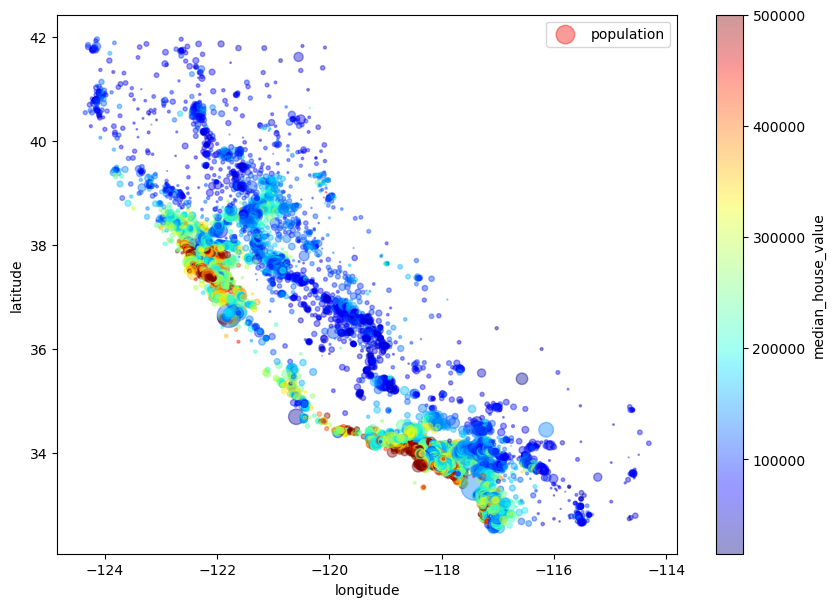

In [ ]:
#analise exploratoria pós separação treino-teste
import matplotlib.pyplot as plt


data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
    s=data['population']/100, label='population', figsize=(10,7),
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
    sharex=False)
plt.legend()
plt.show()



In [ ]:
# filtragem (pandas)
data.query('median_house_value < 500000')
# explique como funciona a filtragem acima com o pandas
# a função query do pandas permite filtrar o dataframe com base em uma expressão booleana
# no caso acima, estamos filtrando as linhas onde a coluna median_house_value é menor que 500000
# e pq fazemos isso? para remover outliers, por exemplo

# pipeline de pré-processamento (sklearn.pipeline.Pipeline)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

data_num = data.drop('ocean_proximity', axis=1)

num_pipeline.fit(data_num)
data_num_tr = num_pipeline.transform(data_num)

data_num_tr

# explique o que é um pipeline de pré-processamento
# um pipeline de pré-processamento é uma sequência de transformações que serão aplicadas aos dados
# antes de serem usados em um modelo de machine learning
# ele é útil para automatizar o pré-processamento dos dados, garantindo que as mesmas transformações
# sejam aplicadas aos dados de treino e teste

# explique o que foi feito em cada parte do pipeline acima
# 1. SimpleImputer: preenche valores faltantes com a mediana
# 2. StandardScaler: padroniza os dados para que tenham média 0 e variância 1


array([[-1.32783522,  1.05254828,  0.98214266, ..., -0.97703285,
         2.34476576,  2.12963148],
       [-1.32284391,  1.04318455, -0.60701891, ...,  1.66996103,
         2.33223796,  1.31415614],
       [-1.33282653,  1.03850269,  1.85618152, ..., -0.84363692,
         1.7826994 ,  1.25869341],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.17404163,
        -1.14259331, -0.99274649],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.39375258,
        -1.05458292, -1.05860847],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.07967221,
        -0.78012947, -1.01787803]], shape=(20640, 9))

### Filtragem

Atividade: Baseado no que aprendemos na análise exploratória, escreva um código para filtrar o *dataset*. Não modifique as colunas, apenas aceite ou rejeite cada linha de dados.

Salve o resultado do processamento na forma de um arquivo "Parquet": https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html

## Processamento dos dados e Pipelines

## Escolha de modelos

## Avaliação